In [1]:
import os
import sys
import pandas as pd
import numpy as np
import ipyvolume as ipv
from scipy import optimize

import json
import matplotlib.pylab as plt
%matplotlib inline

from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.collisions.solvers import CollisionSolver
from tyssue import config
from tyssue.generation import ellipsoid_sheet
from tyssue.generation import extrude

from tyssue.dynamics import effectors, units
from tyssue.dynamics.factory import model_factory

from tyssue import Monolayer, Sheet
from tyssue import MonoLayerGeometry, ClosedMonolayerGeometry
from invagination.ellipsoid import EllipsoidGeometry as geometry
from tyssue.dynamics import BulkModel as bulk_model
from tyssue.generation import three_faces_sheet, extrude
from tyssue.topology.bulk_topology import IH_transition, HI_transition

from datetime import datetime
from tyssue.draw import highlight_cells

from tyssue.draw import sheet_view
from tyssue.io import hdf5

In [2]:
dirname = "../test_ellipsoid"

In [3]:
from tyssue import SheetGeometry
from tyssue.dynamics.bulk_gradients import volume_grad, all_volume_grad

class EllipsoidGeometry(ClosedMonolayerGeometry):

    @staticmethod
    def update_rho(sheet):
        a, b, c = sheet.settings['abc']
        sheet.vert_df["rho2"] = (  
        (sheet.vert_df.x/a)**2
         + (sheet.vert_df.y/b)**2
         + (sheet.vert_df.z/c)**2)
        
    @staticmethod
    def update_lumen_vol(eptm):
        """

        """
        if "lumen_side" in eptm.settings:

            lumen_edges = eptm.edge_df[
                eptm.edge_df.segment == eptm.settings["lumen_side"]
            ].copy()
            lumen_pos_faces = lumen_edges[["f" + c for c in eptm.coords]].values
            # minus sign correct inverted faces orientation
            lumen_edges["lumen_sub_vol"] = -(
                np.sum((lumen_pos_faces) * lumen_edges[eptm.ncoords].values, axis=1) / 6
            )
            eptm.settings["lumen_vol"] = eptm.sum_cell(lumen_edges["lumen_sub_vol"]).sum().values[0]
        else:
            lumen_pos_faces = eptm.edge_df[["f" + c for c in eptm.coords]].values
            eptm.edge_df["lumen_sub_vol"] = (
                np.sum((lumen_pos_faces) * eptm.edge_df[eptm.ncoords].values, axis=1)
                / 6
            )
            eptm.settings["lumen_vol"] = sum(eptm.edge_df["lumen_sub_vol"])


    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_rho(sheet)


geom = EllipsoidGeometry

class VitellineElasticity(effectors.AbstractEffector):

    dimensions = None
    magnitude = 'ellipsoid_constraint'
    label = "Ellipsoidal shell sticking constraint"
    element = 'vert'
    specs = {"settings": {"abc": (1., 1., 1.)},
             "vert": {'vitelline_K': 1.}}

    def energy(sheet):
        return sheet.vert_df.eval('0.5 * vitelline_K * (rho2 - 1)').clip(lower=0)

    def gradient(sheet):
        a, b, c = sheet.settings['abc']
        grad = pd.DataFrame(index=sheet.vert_df.index,
                            columns=['gx', 'gy', 'gz'])
        const = sheet.vert_df.eval(
                f'vitelline_K').values
        
        outside = sheet.vert_df['rho2'] > 1
        
        const = const*outside.astype(float)

        for coord, axis in zip(['x', 'y', 'z'], (a, b, c)):
            grad['g'+coord] = const * sheet.vert_df[coord].values / axis**2

        return grad, None
    
def lumen_volume_grad(eptm):
    """
    Calculate volume gradient for the all object.
    For example calculate the yolk volume of the embryo.
    """
    coords = eptm.coords
    if "segment" in eptm.edge_df:
        basal_edges = eptm.edge_df[eptm.edge_df.segment == eptm.settings["lumen_side"]].copy()
        face_pos = basal_edges[["f" + c for c in coords]].values
        srce_pos = basal_edges[["s" + c for c in coords]].values
        trgt_pos = basal_edges[["t" + c for c in coords]].values
        grad_v_srce = np.cross((trgt_pos), (face_pos)) / 4
        grad_v_trgt = -np.cross((srce_pos), (face_pos)) / 4
        return (
            pd.DataFrame(grad_v_srce, index=basal_edges.index, columns=eptm.coords),
            pd.DataFrame(grad_v_trgt, index=basal_edges.index, columns=eptm.coords),
        )
    else:
        face_pos = eptm.edge_df[["f" + c for c in coords]].values
        srce_pos = eptm.edge_df[["s" + c for c in coords]].values
        trgt_pos = eptm.edge_df[["t" + c for c in coords]].values

        grad_v_srce = np.cross((trgt_pos), (face_pos)) / 4
        grad_v_trgt = -np.cross((srce_pos), (face_pos)) / 4
        return (
            pd.DataFrame(grad_v_srce, index=eptm.edge_df.index, columns=eptm.coords),
            pd.DataFrame(grad_v_trgt, index=eptm.edge_df.index, columns=eptm.coords),
        )
    
class LumenVolumeElasticity(effectors.AbstractEffector):
    """
    Global volume elasticity of the object.
    For example the volume of the yolk in the Drosophila embryo
    """

    dimensions = units.vol_elasticity
    magnitude = "lumen_vol_elasticity"
    label = "Lumen volume elasticity"
    element = "settings"
    spatial_ref = "lumen_prefered_vol", units.vol

    specs = {"settings": {"lumen_vol", "lumen_vol_elasticity", "lumen_prefered_vol"}}

    @staticmethod
    def get_nrj_norm(specs):
        return (
            specs["settings"]["lumen_vol_elasticity"]
            * specs["settings"]["lumen_prefered_vol"] ** 2
        )

    @staticmethod
    def energy(eptm):

        return effectors._elastic_energy(
            eptm.settings, "lumen_vol", "lumen_vol_elasticity", "lumen_prefered_vol"
        )

    @staticmethod
    def gradient(eptm):
        kv_v0 = effectors._elastic_force(
            eptm.settings, "lumen_vol", "lumen_vol_elasticity", "lumen_prefered_vol"
        )

        grad_v_srce, grad_v_trgt = lumen_volume_grad(eptm)
        grad_v_srce = kv_v0 * grad_v_srce
        grad_v_trgt = kv_v0 * grad_v_trgt

        grad_v_srce.columns = ["g" + u for u in eptm.coords]
        grad_v_trgt.columns = ["g" + u for u in eptm.coords]

        return grad_v_srce, grad_v_trgt


In [4]:
def view3d(mono):
    ipv.clear()
    draw_spec = config.draw.sheet_spec()
    draw_spec['face']['visible'] = True 
    draw_spec['face']['color'] = mono.face_df.area
    draw_spec['face']['color_range'] = (0, 1)
    # function plotting two meshes
    fig, meshes = sheet_view(mono, mode='3D', **draw_spec)
    fig = ipv.gcf()

    #mesh = ipv.examples.klein_bottle(show=False)
    #fig.meshes = fig.meshes + [mesh, ]
    fig.anglex = 1.0
    fig.angley = 0.2
    fig.anglez = 0.1
    
    ipv.show()
    #timestamp = datetime.now().isoformat().replace(':', '').replace('.', '_')
    #ipv.savefig(f'{mono.identifier}_{timestamp}.png')


In [5]:
model = model_factory(
    [
        VitellineElasticity,
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.CellAreaElasticity,
        effectors.CellVolumeElasticity,
        LumenVolumeElasticity
    ],
    effectors.CellVolumeElasticity,
)



### Ellipsoid

In [24]:
specs =  {
    'vert': {
        'is_active': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'rho': 0,
        'height': 0,
        'basal_shift': 0,
        'delta_rho': 30,
        'vitelline_K': 280.0,
        'radial_tension': 0},
    'face': {
        'is_alive': 1,
        'x': 0.0,
        'y': 0.0,
        'z': 0.0,
        'num_sides': 6,
        'area': 1.0,
        'perimeter': 1.0,
        'contractility': 1.12,
        'prefered_area': 22,
        'area_elasticity': 1,
        'surface_tension': 10.
    },
    'cell': {
        'vol': 100.0,
        'vol_elasticity': 5e-3,
        'prefered_vol': 100.0,
    },
    'edge': {
        'is_active': 1,
        'srce': 0,
        'trgt': 0,
        'face': 0,
        'cell': 0,
        'dx': 0.0,
        'dy': 0.0,
        'dz': 0.0,
        'nx': 0.0,
        'ny': 0.0,
        'nz': 0.0,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0,
        'length': 0.0,
        'sub_vol': 0.0,
        'sub_area': 0.0,
        'line_tension': 0.0,
    },
    'settings': {
        'abc': [12, 12, 21.0], # Ellipsoid axes
        'geometry': 'cylindrical',
        'height_axis': 'z',
        'nrj_norm_factor': 1,
        'vitelline_space': 0.2,
        'threshold_length': 1e-3,
        'lumen_vol': 12000,
        'lumen_prefered_vol': 15000,
        'lumen_vol_elasticity': 3.e-6,
        'lumen_side': 'basal',
        'vitelline_space':0.2,
    }
}


In [57]:
mono.settings

{'abc': [12, 12, 21.0],
 'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_prefered_vol': 2308882.594962905,
 'lumen_side': 'basal',
 'lumen_vol': 2307908.308358888,
 'lumen_vol_elasticity': 3,
 'nrj_norm_factor': 1.0,
 'threshold_length': 0.001,
 'vitelline_space': 0.2}

In [53]:
from tyssue.solvers.isotropic_solver import bruteforce_isotropic_relax

sheet = ellipsoid_sheet(*specs['settings']['abc'], 77, pos_err=1e-2, phase_err=1e-2)

dsets = hdf5.load_datasets('/home/admin-suz/Documents/Simulations/test/1.08_contractility_5_critical_area_30_radialtension_0/invagination_0000.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('ellipse', dsets, specs)
mono_datasets = extrude(sheet.datasets, method="homotecy", scale = 0.8)
mono = Monolayer('mono', mono_datasets, specs)
print(f'The sheet has {sheet.Nf} vertices')

geom.center(mono)
geom.update_all(mono)
mono.settings["lumen_prefered_vol"] = mono.settings["lumen_vol"]
mono.settings["lumen_vol_elasticity"] = 3 #3.e-6


dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.1
dyn_specs['cell']['prefered_area'] = mono.cell_df["area"].mean()*0.8
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] =  mono.cell_df["vol"].mean()*1.
dyn_specs['face']['contractility'] = 1e-2
dyn_specs['face']['prefered_area'] = mono.face_df["area"].mean()*0.8
dyn_specs['edge']['line_tension'] = 1e-3


mono.update_specs(dyn_specs, reset=True)

res=bruteforce_isotropic_relax(mono, geom, model)

#mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
#mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

success = False
i=0
while not success:
    res = Solver.find_energy_min(mono, geom, model)
    success = res.success
    print(i)
    i+=1

mono.face_df.visible=True
view3d(mono)
print(res)

/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3rc1-py3.6-linux-x86_64.egg/tyssue/utils/utils.py:87: UserWarning: There is no cell dataset, so the cell spec have no effect.
  f"There is no {name} dataset, so the {name}" " spec have no effect."


The sheet has 5947 vertices


Reseting column vol_elasticity of the cell dataset with new specs
Reseting column prefered_vol of the cell dataset with new specs
Reseting column area_elasticity of the cell dataset with new specs
Reseting column prefered_area of the cell dataset with new specs
Reseting column is_alive of the cell dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column is_alive of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


0
1


VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[11775, 11852],
       [11308, 11625],
       [ 7592,  7593],
       ...,
       [    0, 11890],
       [11890, 13255],
       [13255,  1365]], dtype=uint32), texture=None, x=array([-33.31814819, -47.97999913,  -2.89091341, ..., -21.14180882,
       -19.34442712, -19.47168331]), y=array([-59.99032944,  55.47362462, -69.25321706, ...,  60.96071001,
        61.32009154,  60.57013241]), z=array([ 87.46352178, -77.01880626,  85.2565671 , ..., -39.0843721 ,
       -39.99816378, -43.39437704])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936]]), texture=None, triangles=array([[  5795,  47564, 261584],
       [  5810,  47565, 261585],
       [  4723,  47566, 261586],
       ...,
       [ 47563, 261581, 475601],
       [ 47563, 261582, 475602],
       [ 47563, 261583, 475603]], dtype=uint32), x=array([-34.25246925, -34.90681712, -30.60404867, ..., -26.65460993,
       -28.79113601, -35.95290093]), y=array([-60.87028412, -57.84832831, -60.50574732, ..., -48.02880372,
       -47.08585577, -58.83365718]), z=array([84.47128241, 89.57313111, 88.97345766, ..., 70.04339739,
       69.28874069, 86.69369552]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-165.0891502028955, 164.76067808229655], ylim=[-165.0891502028955, 164.76067808229655], zlim=[-165.0891502028955, 164.76067808229655]),))

      fun: 149475665.32743582
 hess_inv: <71340x71340 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 135.90858334, -633.08187136,   49.99310901, ...,   -8.91581535,
        363.61763663,   51.70785741])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 19
      nit: 1
   status: 0
  success: True
        x: array([-33.31814819, -59.99032944,  87.46352178, ..., -19.47168331,
        60.57013241, -43.39437704])


In [59]:
sub_mono=mono.copy()

edge_cut_out = sub_mono.cut_out(np.array([[-200, 200.0], [-200., 200.0], [-250,0.0]]))
sub_mono.remove(edge_cut_out)
sub_mono.face_df.visible=False
view3d(sub_mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 5598,  5773],
       [ 4639,  3525],
       [ 3522,  3521],
       ...,
       [ 4434, 10357],
       [10357, 10363],
       [10363,  4440]], dtype=uint32), texture=None, x=array([-47.97999913, -61.93050564,  44.69483306, ..., -21.14180882,
       -19.34442712, -19.47168331]), y=array([ 55.47362462, -58.66680523, -57.72682175, ...,  60.96071001,
        61.32009154,  60.57013241]), z=array([-77.01880626,  -0.59733975, -77.20624552, ..., -39.0843721 ,
       -39.99816378, -43.39437704])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936]]), texture=None, triangles=array([[  2823,  23161, 127375],
       [  2217,  23162, 127376],
       [  2216,  23163, 127377],
       ...,
       [ 23160, 127372, 231586],
       [ 23160, 127373, 231587],
       [ 23160, 127374, 231588]], dtype=uint32), x=array([-47.182699  , -49.77735258, -45.34063041, ..., -29.64980405,
       -30.27299457, -37.80522414]), y=array([ 54.49618673,  54.67932496,  57.346045  , ..., -51.06424789,
       -50.78302718, -63.51451778]), z=array([-80.32687292, -74.9083076 , -77.39367157, ..., -60.07756681,
       -59.72161415, -74.59400829]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-158.61958232508314, 93.83179762374772], ylim=[-158.61958232508314, 93.83179762374772], zlim=[-158.61958232508314, 93.83179762374772]),))

In [60]:
from tyssue.io import obj, hdf5

obj.save_junction_mesh("3d_embryo.obj", mono)
hdf5.save_datasets("3d_embryo.hf5", mono)



                be advised the file cannot be read back in vispy
/home/admin-suz/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['edge_o', 'srce_o', 'trgt_o', 'face_o', 'cell_o', 'lumen_sub_vol', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['num_sides', 'face_o', 'height', 'rho', 'area_elasticity', 'prefered_height', 'prefered_vol', 'surface_tension', 'is_mesoderm', 'id', 'enter_in_process', 'is_relaxation', 'contract_rate', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_

In [61]:
with open('3D_embryo.json', 'w') as fp:
    json.dump(mono.settings, fp)

(<matplotlib.figure.Figure at 0x7f344b10fdd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f342070e2b0>)

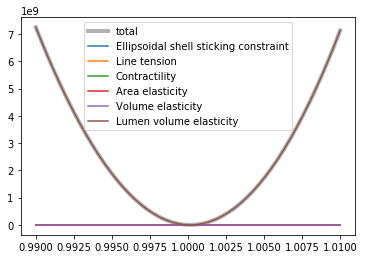

In [56]:
from tyssue.draw.plt_draw import plot_scaled_energies
plot_scaled_energies(mono, geom, model, np.linspace(0.99,1.01))


In [27]:
mono.face_df.visible=False
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 959,  291],
       [ 291, 1257],
       [3895, 3894],
       ...,
       [2212, 8128],
       [8128, 5916],
       [5916,    0]], dtype=uint32), texture=None, x=array([-1.57556933,  5.54600363,  0.34648183, ..., -4.77565966,
       -5.22822068, -5.51733884]), y=array([-4.8791107 ,  4.55179408,  8.28389286, ..., -0.34273121,
       -0.01053978, -0.24882669]), z=array([-7.78667366,  7.62544236,  9.69961364, ..., 13.59730657,
       13.3826441 , 13.06935925])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.21813 , 0.347432, 0.550038],
       [0.21813 , 0.347432, 0.550038],
       [0.21813 , 0.347432, 0.550038]]), texture=None, triangles=array([[   455,  23696, 130268],
       [   455,  23697, 130269],
       [  2459,  23698, 130270],
       ...,
       [ 23695, 130265, 236837],
       [ 23695, 130266, 236838],
       [ 23695, 130267, 236839]], dtype=uint32), x=array([-1.00560176, -2.20327162, -2.20242476, ..., -2.1995702 ,
       -2.23169506, -1.57556933]), y=array([-4.09225646, -5.21123382, -4.65268153, ..., -4.01708177,
       -4.02536752, -4.8791107 ]), z=array([-7.67557367, -7.22843536, -8.28851087, ..., -7.21880743,
       -7.28775906, -7.78667366]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-16.12200150531694, 19.74516548359305], ylim=[-16.12200150531694, 19.74516548359305], zlim=[-16.12200150531694, 19.74516548359305]),))

In [25]:
from tyssue.io import obj
obj.save_junction_mesh('3d_test4.obj', mono)

                be advised the file cannot be read back in vispy


In [3]:
specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 4, 5, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('mono', datasets, specs)

geom.center(mono)
geom.update_all(mono)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.2
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

res = Solver.find_energy_min(mono, geom, model)



Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


In [4]:

def view3d(mono):
    ipv.clear()
    draw_spec = config.draw.sheet_spec()
    draw_spec['face']['visible'] = True 
    draw_spec['face']['color'] = mono.face_df.area
    draw_spec['face']['color_range'] = (0, 1)
    # function plotting two meshes
    fig, meshes = sheet_view(mono, mode='3D', **draw_spec)
    fig = ipv.gcf()

    #mesh = ipv.examples.klein_bottle(show=False)
    #fig.meshes = fig.meshes + [mesh, ]
    fig.anglex = 1.0
    fig.angley = 0.2
    fig.anglez = 0.1
    
    ipv.show()
    #timestamp = datetime.now().isoformat().replace(':', '').replace('.', '_')
    #ipv.savefig(f'{mono.identifier}_{timestamp}.png')


In [42]:
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[11775, 11852],
       [11308, 11625],
       [ 7592,  7593],
       ...,
       [    0, 11890],
       [11890, 13255],
       [13255,  1365]], dtype=uint32), texture=None, x=array([-33.32251191, -47.97585895,  -2.89519346, ..., -21.13798725,
       -19.34875242, -19.47600896]), y=array([-59.98853147,  55.47085331, -69.25767958, ...,  60.96514974,
        61.32453226,  60.57457106]), z=array([ 87.46803438, -77.02329014,  85.26107363, ..., -39.08875168,
       -40.00254587, -43.39022424])), Mesh(color=array([[0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       ...,
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936]]), texture=None, triangles=array([[  5795,  47564, 261584],
       [  5810,  47565, 261585],
       [  4723,  47566, 261586],
       ...,
       [ 47563, 261581, 475601],
       [ 47563, 261582, 475602],
       [ 47563, 261583, 475603]], dtype=uint32), x=array([-34.25466462, -34.9070906 , -30.60918795, ..., -26.65895533,
       -28.78694306, -35.94872768]), y=array([-60.87167263, -57.85081155, -60.50732394, ..., -48.02466367,
       -47.08741898, -58.83809105]), z=array([84.47311661, 89.57449258, 88.97194312, ..., 70.03965548,
       69.29320331, 86.698206  ]))], style={'axes': {'visible': False, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': False}, 'background-color': 'black'}, tf=None, width=400, xlim=[-165.09387623951213, 164.7568589998481], ylim=[-165.09387623951213, 164.7568589998481], zlim=[-165.09387623951213, 164.7568589998481]),))

In [28]:
highlight_cells(mono, 4)
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 959,  291],
       [ 291, 1257],
       [3895, 3894],
       ...,
       [2212, 8128],
       [8128, 5916],
       [5916,    0]], dtype=uint32), texture=None, x=array([-1.57556933,  5.54600363,  0.34648183, ..., -4.77565966,
       -5.22822068, -5.51733884]), y=array([-4.8791107 ,  4.55179408,  8.28389286, ..., -0.34273121,
       -0.01053978, -0.24882669]), z=array([-7.78667366,  7.62544236,  9.69961364, ..., 13.59730657,
       13.3826441 , 13.06935925])), Mesh(color=array([[0.845561, 0.887322, 0.099702],
       [0.555484, 0.840254, 0.269281],
       [0.134692, 0.658636, 0.517649],
       [0.993248, 0.906157, 0.143936],
       [0.35236 , 0.783011, 0.392636],
       [0.120081, 0.622161, 0.534946],
       [0.496615, 0.826376, 0.306377],
       [0.647257, 0.8584  , 0.209861],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.845561, 0.887322, 0.099702],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.35236 , 0.783011, 0.392636],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.555484, 0.840254, 0.269281],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.134692, 0.658636, 0.517649],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.993248, 0.906157, 0.143936],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.120081, 0.622161, 0.534946],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.496615, 0.826376, 0.306377],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861],
       [0.647257, 0.8584  , 0.209861]]), texture=None, triangles=array([[ 0,  8, 44]

In [7]:
from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.monolayer.delamination_events import constriction

#Initiate manager
manager = EventManager('face')
sheet.face_df['enter_in_process'] = 0  

t=0
stop = 40

mono.settings['constriction'] = {}
mono.cell_df["is_mesoderm"] = False

cell_to_constrict = 4
mono.cell_df.loc[cell_to_constrict, "is_mesoderm"] = True
mono.cell_df["id"] = mono.cell_df.index.values


delam_kwargs = mono.settings['constriction'].copy()
delam_kwargs.update(
            {
                'cell_id':cell_to_constrict,
                'contract_rate': 2,
                'critical_area': 0.02,
                'shrink_rate':0.4,
                'critical_volume':0.1, 
                'radial_tension': 30,
                'max_traction': 10, 
                'contract_neighbors': False
            }
        )
        

manager.append(constriction, **delam_kwargs)

while manager.current and t<stop:
    print (t)
    mono.edge_df.line_tension = 0
    manager.execute(mono)
    res = Solver.find_energy_min(mono, geom, model)
    
    figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
    hdfname = figname[:-3]+'hf5'
    hdf5.save_datasets(hdfname, sheet)
    
    manager.update()
    t+=1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [8]:
mono.face_df.visible=True
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 2,  0],
       [ 1,  2],
       [ 3,  6],
       [ 4,  3],
       [ 5,  4],
       [ 5,  7],
       [ 7,  5],
       [ 6,  7],
       [ 7,  6],
       [ 0,  8],
       [ 8,  9],
       [ 2, 10],
       [10,  2],
       [ 8, 12],
       [12,  8],
       [10, 12],
       [12, 10],
       [16, 14],
       [14, 15],
       [ 9, 16],
       [12, 13],
       [13, 12],
       [13, 14],
       [14, 13],
       [15,  5],
       [ 7, 11],
       [11,  7],
       [11, 13],
       [13, 11],
       [10, 18],
       [18, 10],
       [11, 17],
       [17, 11],
       [17, 18],
       [18, 17],
       [19, 21],
       [19, 20],
       [20, 19],
       [20, 22],
       [22, 20],
       [21, 23],
       [23, 22],
       [ 6, 19],
       [17, 20],
       [20, 17],
       [25, 24],
       [26, 25],
       [22, 26],
       [24,  1],
       [18, 25],
       [25, 18],
       [27, 29],
       [29, 28],
       [33, 30],
       [30, 31],
       [31, 32],
       [34, 32],
       [32, 34],
       [34, 33],
       [33, 34],
       [35, 27],
       [36, 35],
       [37, 29],
       [29, 37],
       [39, 35],
       [35, 39],
       [39, 37],
       [37, 39],
       [41, 43],
       [42, 41],
       [43, 36],
       [40, 39],
       [39, 40],
       [41, 40],
       [40, 41],
       [32, 42],
       [38, 34],
       [34, 38],
       [40, 38],
       [38, 40],
       [45, 37],
       [37, 45],
       [44, 38],
       [38, 44],
       [45, 44],
       [44, 45],
       [48, 46],
       [47, 46],
       [46, 47],
       [49, 47],
       [47, 49],
       [50, 48],
       [49, 50],
       [46, 33],
       [47, 44],
       [44, 47],
       [51, 52],
       [52, 53],
       [53, 49],
       [28, 51],
       [52, 45],
       [45, 52],
       [ 0,  2],
       [ 2, 29],
       [29, 27],
       [27,  0],
       [ 2,  1],
       [ 1, 28],
       [28, 29],
       [29,  2],
       [ 6,  3],
       [ 3, 30],
       [30, 33],
       [33,  6],
       [ 3,  4],
       [ 4, 31],
       [31, 30],
       [30,  3],
       [ 4,  5],
       [ 5, 32],
       [32, 31],
       [31,  4],
       [ 7,  5],
       [ 5, 32],
       [32, 34],
       [34,  7],
       [ 5,  7],
       [ 7, 34],
       [34, 32],
       [32,  5],
       [ 7,  6],
       [ 6, 33],
       [33, 34],
       [34,  7],
       [ 6,  7],
       [ 7, 34],
       [34, 33],
       [33,  6],
       [ 8,  0],
       [ 0, 27],
       [27, 35],
       [35,  8],
       [ 9,  8],
       [ 8, 35],
       [35, 36],
       [36,  9],
       [10,  2],
       [ 2, 29],
       [29, 37],
       [37, 10],
       [ 2, 10],
       [10, 37],
       [37, 29],
       [29,  2],
       [12,  8],
       [ 8, 35],
       [35, 39],
       [39, 12],
       [ 8, 12],
       [12, 39],
       [39, 35],
       [35,  8],
       [12, 10],
       [10, 37],
       [37, 39],
       [39, 12],
       [10, 12],
       [12, 39],
       [39, 37],
       [37, 10],
       [14, 16],
       [16, 43],
       [43, 41],
       [41, 14],
       [15, 14],
       [14, 41],
       [41, 42],
       [42, 15],
       [16,  9],
       [ 9, 36],
       [36, 43],
       [43, 16],
       [13, 12],
       [12, 39],
       [39, 40],
       [40, 13],
       [12, 13],
       [13, 40],
       [40, 39],
       [39, 12],
       [14, 13],
       [13, 40],
       [40, 41],
       [41, 14],
       [13, 14],
       [14, 41],
       [41, 40],
       [40, 13],
       [ 5, 15],
       [15, 42],
       [42, 32],
       [32,  5],
       [11,  7],
       [ 7, 34],
       [34, 38],
       [38, 11],
       [ 7, 11],
       [11, 38],
       [38, 34],
       [34,  7],
       [13, 11],
       [11, 38],
       [38, 40],
       [40, 13],
       [11

In [9]:
highlight_cells(mono, 4, reset_visible=True)
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[ 2,  0],
       [ 1,  2],
       [ 3,  6],
       [ 4,  3],
       [ 5,  4],
       [ 5,  7],
       [ 7,  5],
       [ 6,  7],
       [ 7,  6],
       [ 0,  8],
       [ 8,  9],
       [ 2, 10],
       [10,  2],
       [ 8, 12],
       [12,  8],
       [10, 12],
       [12, 10],
       [16, 14],
       [14, 15],
       [ 9, 16],
       [12, 13],
       [13, 12],
       [13, 14],
       [14, 13],
       [15,  5],
       [ 7, 11],
       [11,  7],
       [11, 13],
       [13, 11],
       [10, 18],
       [18, 10],
       [11, 17],
       [17, 11],
       [17, 18],
       [18, 17],
       [19, 21],
       [19, 20],
       [20, 19],
       [20, 22],
       [22, 20],
       [21, 23],
       [23, 22],
       [ 6, 19],
       [17, 20],
       [20, 17],
       [25, 24],
       [26, 25],
       [22, 26],
       [24,  1],
       [18, 25],
       [25, 18],
       [27, 29],
       [29, 28],
       [33, 30],
       [30, 31],
       [31, 32],
       [34, 32],
       [32, 34],
       [34, 33],
       [33, 34],
       [35, 27],
       [36, 35],
       [37, 29],
       [29, 37],
       [39, 35],
       [35, 39],
       [39, 37],
       [37, 39],
       [41, 43],
       [42, 41],
       [43, 36],
       [40, 39],
       [39, 40],
       [41, 40],
       [40, 41],
       [32, 42],
       [38, 34],
       [34, 38],
       [40, 38],
       [38, 40],
       [45, 37],
       [37, 45],
       [44, 38],
       [38, 44],
       [45, 44],
       [44, 45],
       [48, 46],
       [47, 46],
       [46, 47],
       [49, 47],
       [47, 49],
       [50, 48],
       [49, 50],
       [46, 33],
       [47, 44],
       [44, 47],
       [51, 52],
       [52, 53],
       [53, 49],
       [28, 51],
       [52, 45],
       [45, 52],
       [ 0,  2],
       [ 2, 29],
       [29, 27],
       [27,  0],
       [ 2,  1],
       [ 1, 28],
       [28, 29],
       [29,  2],
       [ 6,  3],
       [ 3, 30],
       [30, 33],
       [33,  6],
       [ 3,  4],
       [ 4, 31],
       [31, 30],
       [30,  3],
       [ 4,  5],
       [ 5, 32],
       [32, 31],
       [31,  4],
       [ 7,  5],
       [ 5, 32],
       [32, 34],
       [34,  7],
       [ 5,  7],
       [ 7, 34],
       [34, 32],
       [32,  5],
       [ 7,  6],
       [ 6, 33],
       [33, 34],
       [34,  7],
       [ 6,  7],
       [ 7, 34],
       [34, 33],
       [33,  6],
       [ 8,  0],
       [ 0, 27],
       [27, 35],
       [35,  8],
       [ 9,  8],
       [ 8, 35],
       [35, 36],
       [36,  9],
       [10,  2],
       [ 2, 29],
       [29, 37],
       [37, 10],
       [ 2, 10],
       [10, 37],
       [37, 29],
       [29,  2],
       [12,  8],
       [ 8, 35],
       [35, 39],
       [39, 12],
       [ 8, 12],
       [12, 39],
       [39, 35],
       [35,  8],
       [12, 10],
       [10, 37],
       [37, 39],
       [39, 12],
       [10, 12],
       [12, 39],
       [39, 37],
       [37, 10],
       [14, 16],
       [16, 43],
       [43, 41],
       [41, 14],
       [15, 14],
       [14, 41],
       [41, 42],
       [42, 15],
       [16,  9],
       [ 9, 36],
       [36, 43],
       [43, 16],
       [13, 12],
       [12, 39],
       [39, 40],
       [40, 13],
       [12, 13],
       [13, 40],
       [40, 39],
       [39, 12],
       [14, 13],
       [13, 40],
       [40, 41],
       [41, 14],
       [13, 14],
       [14, 41],
       [41, 40],
       [40, 13],
       [ 5, 15],
       [15, 42],
       [42, 32],
       [32,  5],
       [11,  7],
       [ 7, 34],
       [34, 38],
       [38, 11],
       [ 7, 11],
       [11, 38],
       [38, 34],
       [34,  7],
       [13, 11],
       [11, 38],
       [38, 40],
       [40, 13],
       [11

### Ellipsoid tissue

In [59]:
specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 10, 10, 1, 1)
sheet.sanitize()
datasets = extrude(sheet.datasets, method='translation')
mono = Monolayer('mono', datasets, specs)

geom.center(mono)
geom.update_all(mono)

dyn_specs = config.dynamics.quasistatic_bulk_spec()
dyn_specs['cell']['area_elasticity'] = 0.05
dyn_specs['cell']['prefered_area'] = 6.
dyn_specs['cell']['vol_elasticity'] = 1.
dyn_specs['cell']['prefered_vol'] = 1.2
dyn_specs['face']['contractility'] = 0.0
dyn_specs['edge']['line_tension'] = 0.0


mono.update_specs(dyn_specs, reset=True)


mono.face_df.loc[mono.apical_faces, 'contractility'] = 1e-3
mono.face_df.loc[mono.basal_faces, 'contractility'] = 1e-3

res = CollisionSolver.find_energy_min(mono, geom, model)

mono.face_df.visible=True
view3d(mono)

Reseting column is_alive of the cell dataset with new specs
Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[  9,   8],
       [ 12,   9],
       [ 10,  12],
       ...,
       [167, 337],
       [337, 329],
       [329, 159]], dtype=uint32), texture=None, x=array([-3.1275337 , -2.61473013, -2.61863664, -2.63388912, -3.12453059,
        0.24748812, -3.10004547, -2.61477656, -4.621135  , -4.11034644,
       -4.58898604, -4.09338485, -4.09854188, -4.1225095 , -3.53930377,
       -4.6144177 , -4.10090716, -3.53459604, -3.07551296, -4.64114627,
       -4.25138163, -3.54419581, -4.12138168, -3.56979849,  1.18820521,
        1.68108813,  1.18217805,  1.66710313,  1.66506101,  2.16283585,
       -2.62387481, -4.10891706, -3.60781825, -4.09015908, -3.11666296,
        1.19538297,  1.66302647, -0.7223734 ,  4.6144177 ,  4.10090716,
        1.20067643,  0.71213807, -0.24201797,  0.23561512,  0.7105922 ,
        1.66847939,  1.18239863,  2.13602443,  2.13701469,  4.621135  ,
        4.11034644,  3.53896707,  4.58898604,  4.09338485,  4.09854188,
       -2.15652438, -1.68384032, -1.19632298, -2.16283585, -1.66506101,
       -1.20067643, -0.71997862,  0.23356947, -0.71464742,  0.23336947,
       -0.24212863, -3.51610172, -3.09735449, -3.51675148, -3.53896707,
       -3.1114812 , -3.5337746 , -0.2362755 , -0.71426913,  4.64114627,
        1.21537492,  0.71997862,  0.7223734 ,  1.19632298,  2.13918554,
        3.10231606,  2.61288223,  2.13749597,  0.70560513,  1.18310835,
        1.65080653,  1.1814335 ,  0.70559817,  1.65147822,  3.53459604,
        3.10004547,  2.61477656,  2.61473013,  3.60781825,  4.09015908,
        4.10891706,  3.5337746 ,  0.23456922,  0.72515813, -0.24748812,
       -2.15258602, -1.66932822, -1.21537492, -3.10293836, -3.10231606,
       -2.59708807, -2.13918554, -2.59613871,  0.23608273, -0.23608273,
       -1.68108813, -2.14349319,  0.24201797,  3.07551296,  4.25138163,
        3.54419581,  3.56979849,  3.12453059,  4.12138168,  4.1225095 ,
        3.1275337 ,  3.53930377,  2.63388912,  2.15652438,  1.68384032,
        2.15258602,  2.61863664,  1.66932822,  3.51610172,  3.10293836,
        2.59613871,  3.09735449,  2.59708807,  3.51675148,  2.61152362,
        2.15579405,  3.1114812 ,  2.62387481,  2.14349319,  3.11666296,
       -1.66847939, -2.13749597, -2.61288223, -2.61152362, -2.15579405,
       -1.66302647, -2.13602443, -1.66710313, -2.13701469, -1.18217805,
        0.71426913,  0.2362755 ,  0.71464742,  0.24212863, -0.72515813,
       -0.23456922, -1.18820521, -1.19538297, -0.23561512, -0.7105922 ,
       -0.70559817, -1.1814335 , -1.65147822, -1.65080653, -0.23356947,
       -1.18310835, -0.70560513, -0.71213807, -1.18239863, -0.23336947,
       -3.1275337 , -2.61473013, -2.61863664, -2.63388912, -3.12453059,
        0.24748812, -3.10004547, -2.61477656, -4.621135  , -4.11034644,
       -4.58898604, -4.09338485, -4.09854188, -4.1225095 , -3.53930377,
       -4.6144177 , -4.10090716, -3.53459604, -3.07551296, -4.64114627,
       -4.25138163, -3.54419581, -4.12138168, -3.56979849,  1.18820521,
        1.68108813,  1.18217805,  1.66710313,  1.66506101,  2.16283585,
       -2.62387481, -4.10891706, -3.60781825, -4.09015908, -3.11666296,
        1.19538297,  1.66302647, -0.7223734 ,  4.6144177 ,  4.10090716,
        1.20067643,  0.71213807, -0.24201797,  0.23561512,  0.7105922 ,
        1.66847939,  1.18239863,  2.13602443,  2.13701469,  4.621135  ,
        4.11034644,  3.53896707,  4.58898604,  4.09338485,  4.09854188,
       -2.15652438, -1.68384032, -1.19632298, -2.16283585, -1.66506101,
       -1.20067643, -0.71997862,  0.23356947, -0.71464742,  0.23336947,
       -0.24212863, -3.51610172, -3.09735449, -3.51675148, -3.53896707,
       -3.1114812 , -3.5337746 , -

In [27]:
highlight_cells(mono, np.linspace(27,44,18), reset_visible=True)
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[  9,   8],
       [ 12,   9],
       [ 10,  12],
       ...,
       [167, 337],
       [337, 329],
       [329, 159]], dtype=uint32), texture=None, x=array([-3.1275337 , -2.61473013, -2.61863664, -2.63388912, -3.12453059,
        0.24748812, -3.10004547, -2.61477656, -4.621135  , -4.11034644,
       -4.58898604, -4.09338485, -4.09854188, -4.1225095 , -3.53930377,
       -4.6144177 , -4.10090716, -3.53459604, -3.07551296, -4.64114627,
       -4.25138163, -3.54419581, -4.12138168, -3.56979849,  1.18820521,
        1.68108813,  1.18217805,  1.66710313,  1.66506101,  2.16283585,
       -2.62387481, -4.10891706, -3.60781825, -4.09015908, -3.11666296,
        1.19538297,  1.66302647, -0.7223734 ,  4.6144177 ,  4.10090716,
        1.20067643,  0.71213807, -0.24201797,  0.23561512,  0.7105922 ,
        1.66847939,  1.18239863,  2.13602443,  2.13701469,  4.621135  ,
        4.11034644,  3.53896707,  4.58898604,  4.09338485,  4.09854188,
       -2.15652438, -1.68384032, -1.19632298, -2.16283585, -1.66506101,
       -1.20067643, -0.71997862,  0.23356947, -0.71464742,  0.23336947,
       -0.24212863, -3.51610172, -3.09735449, -3.51675148, -3.53896707,
       -3.1114812 , -3.5337746 , -0.2362755 , -0.71426913,  4.64114627,
        1.21537492,  0.71997862,  0.7223734 ,  1.19632298,  2.13918554,
        3.10231606,  2.61288223,  2.13749597,  0.70560513,  1.18310835,
        1.65080653,  1.1814335 ,  0.70559817,  1.65147822,  3.53459604,
        3.10004547,  2.61477656,  2.61473013,  3.60781825,  4.09015908,
        4.10891706,  3.5337746 ,  0.23456922,  0.72515813, -0.24748812,
       -2.15258602, -1.66932822, -1.21537492, -3.10293836, -3.10231606,
       -2.59708807, -2.13918554, -2.59613871,  0.23608273, -0.23608273,
       -1.68108813, -2.14349319,  0.24201797,  3.07551296,  4.25138163,
        3.54419581,  3.56979849,  3.12453059,  4.12138168,  4.1225095 ,
        3.1275337 ,  3.53930377,  2.63388912,  2.15652438,  1.68384032,
        2.15258602,  2.61863664,  1.66932822,  3.51610172,  3.10293836,
        2.59613871,  3.09735449,  2.59708807,  3.51675148,  2.61152362,
        2.15579405,  3.1114812 ,  2.62387481,  2.14349319,  3.11666296,
       -1.66847939, -2.13749597, -2.61288223, -2.61152362, -2.15579405,
       -1.66302647, -2.13602443, -1.66710313, -2.13701469, -1.18217805,
        0.71426913,  0.2362755 ,  0.71464742,  0.24212863, -0.72515813,
       -0.23456922, -1.18820521, -1.19538297, -0.23561512, -0.7105922 ,
       -0.70559817, -1.1814335 , -1.65147822, -1.65080653, -0.23356947,
       -1.18310835, -0.70560513, -0.71213807, -1.18239863, -0.23336947,
       -3.1275337 , -2.61473013, -2.61863664, -2.63388912, -3.12453059,
        0.24748812, -3.10004547, -2.61477656, -4.621135  , -4.11034644,
       -4.58898604, -4.09338485, -4.09854188, -4.1225095 , -3.53930377,
       -4.6144177 , -4.10090716, -3.53459604, -3.07551296, -4.64114627,
       -4.25138163, -3.54419581, -4.12138168, -3.56979849,  1.18820521,
        1.68108813,  1.18217805,  1.66710313,  1.66506101,  2.16283585,
       -2.62387481, -4.10891706, -3.60781825, -4.09015908, -3.11666296,
        1.19538297,  1.66302647, -0.7223734 ,  4.6144177 ,  4.10090716,
        1.20067643,  0.71213807, -0.24201797,  0.23561512,  0.7105922 ,
        1.66847939,  1.18239863,  2.13602443,  2.13701469,  4.621135  ,
        4.11034644,  3.53896707,  4.58898604,  4.09338485,  4.09854188,
       -2.15652438, -1.68384032, -1.19632298, -2.16283585, -1.66506101,
       -1.20067643, -0.71997862,  0.23356947, -0.71464742,  0.23336947,
       -0.24212863, -3.51610172, -3.09735449, -3.51675148, -3.53896707,
       -3.1114812 , -3.5337746 , -

In [58]:
%pdb

Automatic pdb calling has been turned ON


In [69]:
from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.monolayer.delamination_events import constriction

#Initiate manager
manager = EventManager('face')
sheet.face_df['enter_in_process'] = 0  

t=0
stop = 40

mono.settings['constriction'] = {}
mono.cell_df["is_mesoderm"] = False


for i in np.linspace(27,44,18):
    
    cell_to_constrict = i
    mono.cell_df.loc[cell_to_constrict, "is_mesoderm"] = True
    mono.cell_df["id"] = mono.cell_df.index.values


    delam_kwargs = mono.settings['constriction'].copy()
    delam_kwargs.update(
                {
                    'cell_id':cell_to_constrict,
                    'contract_rate': 2,
                    'critical_area': 1e-2,
                    'shrink_rate':0.4,
                    'critical_volume':0.1, 
                    'radial_tension': 100,
                    'max_traction': 10, 
                    'contract_neighbors': False
                }
            )


    manager.append(constriction, **delam_kwargs)

while manager.current and t<stop:
    print (t)
    mono.edge_df.line_tension = 0
    manager.execute(mono)
    res = CollisionSolver.find_energy_min(mono, geom, model)
    
    figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
    hdfname = figname[:-3]+'hf5'
    hdf5.save_datasets(hdfname, sheet)
    
    manager.update()
    t+=1
    

0


/home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3rc1-py3.6-linux-x86_64.egg/tyssue/collisions/solvers.py:164: UserWarning: The collision was already present or its axis could not be determined
  """The collision was already present or its axis could not be determined"""


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

> /home/admin-suz/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py(3230)get_indexer()
   3228 
   3229         if not self.is_unique:
-> 3230             raise InvalidIndexError('Reindexing only valid with uniquely'
   3231                                     ' valued Index objects')
   3232 

ipdb> q


In [70]:
mono.face_df.visible=True
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[  9,   8],
       [ 12,   9],
       [ 10,  12],
       ...,
       [167, 337],
       [337, 329],
       [329, 159]], dtype=uint32), texture=None, x=array([-2.88804216, -2.39450296, -2.53833212, -2.55025124, -2.90397326,
        0.24442673, -2.71202492, -2.39157981, -4.2626839 , -3.59594889,
       -3.40691618, -3.16995517, -3.35203456, -3.76078606, -3.15890154,
       -4.10730869, -3.21161905, -3.10073975, -3.04849554, -4.4514861 ,
       -4.14690496, -3.43822054, -3.81958274, -3.3940972 ,  1.17832623,
        1.69808712,  1.11754761,  1.57024305,  1.56363101,  2.04564518,
       -2.60540041, -3.84941919, -3.47020951, -3.85702162, -2.97767018,
        1.18902591,  1.59113915, -0.71449519,  4.10730869,  3.21161905,
        1.15379538,  0.6974701 , -0.22997028,  0.24451205,  0.69474524,
        1.59705541,  1.12599654,  1.96733799,  1.96649352,  4.2626839 ,
        3.59594889,  3.23820459,  3.40691618,  3.16995517,  3.35203456,
       -2.04054701, -1.65116938, -1.14845119, -2.04564518, -1.56363101,
       -1.15379538, -0.70892002,  0.22925855, -0.67958986,  0.22719071,
       -0.23148818, -3.01209377, -2.71314541, -3.01223726, -3.23820459,
       -2.95367035, -3.27587974, -0.2232243 , -0.68177293,  4.4514861 ,
        1.21895369,  0.70892002,  0.71449519,  1.14845119,  1.9857301 ,
        2.77730334,  2.44540789,  1.98499142,  0.67271878,  1.12753366,
        1.54895353,  1.11740165,  0.67191297,  1.54897078,  3.10073975,
        2.71202492,  2.39157981,  2.39450296,  3.47020951,  3.85702162,
        3.84941919,  3.27587974,  0.2415722 ,  0.74166947, -0.24442673,
       -2.15206084, -1.63608165, -1.21895369, -2.76      , -2.77730334,
       -2.35678437, -1.9857301 , -2.35351187,  0.22396881, -0.22396881,
       -1.69808712, -2.08605204,  0.22997028,  3.04849554,  4.14690496,
        3.43822054,  3.3940972 ,  2.90397326,  3.81958274,  3.76078606,
        2.88804216,  3.15890154,  2.55025124,  2.04054701,  1.65116938,
        2.15206084,  2.53833212,  1.63608165,  3.01209377,  2.76      ,
        2.35351187,  2.71314541,  2.35678437,  3.01223726,  2.44716864,
        2.0930694 ,  2.95367035,  2.60540041,  2.08605204,  2.97767018,
       -1.59705541, -1.98499142, -2.44540789, -2.44716864, -2.0930694 ,
       -1.59113915, -1.96733799, -1.57024305, -1.96649352, -1.11754761,
        0.68177293,  0.2232243 ,  0.67958986,  0.23148818, -0.74166947,
       -0.2415722 , -1.17832623, -1.18902591, -0.24451205, -0.69474524,
       -0.67191297, -1.11740165, -1.54897078, -1.54895353, -0.22925855,
       -1.12753366, -0.67271878, -0.6974701 , -1.12599654, -0.22719071,
       -3.16940091, -2.64089197, -2.63101548, -2.63228679, -3.18059698,
        0.22125443, -3.20427488, -2.65825177, -4.71001619, -4.24849803,
       -4.93037311, -4.45156417, -4.27374255, -4.2196739 , -3.63539601,
       -4.68290253, -4.36384136, -3.65160719, -3.06838474, -4.71937432,
       -4.39190008, -3.66474544, -4.23093888, -3.62688955,  1.15104691,
        1.58015925,  1.20823095,  1.67311708,  1.66191908,  2.15061737,
       -2.60902053, -4.23556036, -3.70280679, -4.24324434, -3.19741537,
        1.15454717,  1.65618335, -0.68694626,  4.68290253,  4.36384136,
        1.17423436,  0.70334685, -0.23443705,  0.22526847,  0.69931765,
        1.65822957,  1.18721825,  2.22782965,  2.19091139,  4.71001619,
        4.24849803,  3.63510147,  4.93037311,  4.45156417,  4.27374255,
       -2.14670621, -1.62999317, -1.17009729, -2.15061737, -1.66191908,
       -1.17423436, -0.68458323,  0.23754225, -0.70950096,  0.23596812,
       -0.23488003, -3.70216041, -3.26174164, -3.77202591, -3.63510147,
       -3.18178422, -3.66746182, -

In [62]:
highlight_cells(mono, np.linspace(27,44,18), reset_visible=True)
view3d(mono)

VBox(children=(Figure(anglex=1.0, angley=0.2, anglez=0.1, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], meshes=[Mesh(color=array('#2b5d0a', dtype='<U7'), lines=array([[  9,   8],
       [ 12,   9],
       [ 10,  12],
       ...,
       [167, 337],
       [337, 329],
       [329, 159]], dtype=uint32), texture=None, x=array([-2.88804216, -2.39450296, -2.53833212, -2.55025124, -2.90397326,
        0.24442673, -2.71202492, -2.39157981, -4.2626839 , -3.59594889,
       -3.40691618, -3.16995517, -3.35203456, -3.76078606, -3.15890154,
       -4.10730869, -3.21161905, -3.10073975, -3.04849554, -4.4514861 ,
       -4.14690496, -3.43822054, -3.81958274, -3.3940972 ,  1.17832623,
        1.69808712,  1.11754761,  1.57024305,  1.56363101,  2.04564518,
       -2.60540041, -3.84941919, -3.47020951, -3.85702162, -2.97767018,
        1.18902591,  1.59113915, -0.71449519,  4.10730869,  3.21161905,
        1.15379538,  0.6974701 , -0.22997028,  0.24451205,  0.69474524,
        1.59705541,  1.12599654,  1.96733799,  1.96649352,  4.2626839 ,
        3.59594889,  3.23820459,  3.40691618,  3.16995517,  3.35203456,
       -2.04054701, -1.65116938, -1.14845119, -2.04564518, -1.56363101,
       -1.15379538, -0.70892002,  0.22925855, -0.67958986,  0.22719071,
       -0.23148818, -3.01209377, -2.71314541, -3.01223726, -3.23820459,
       -2.95367035, -3.27587974, -0.2232243 , -0.68177293,  4.4514861 ,
        1.21895369,  0.70892002,  0.71449519,  1.14845119,  1.9857301 ,
        2.77730334,  2.44540789,  1.98499142,  0.67271878,  1.12753366,
        1.54895353,  1.11740165,  0.67191297,  1.54897078,  3.10073975,
        2.71202492,  2.39157981,  2.39450296,  3.47020951,  3.85702162,
        3.84941919,  3.27587974,  0.2415722 ,  0.74166947, -0.24442673,
       -2.15206084, -1.63608165, -1.21895369, -2.76      , -2.77730334,
       -2.35678437, -1.9857301 , -2.35351187,  0.22396881, -0.22396881,
       -1.69808712, -2.08605204,  0.22997028,  3.04849554,  4.14690496,
        3.43822054,  3.3940972 ,  2.90397326,  3.81958274,  3.76078606,
        2.88804216,  3.15890154,  2.55025124,  2.04054701,  1.65116938,
        2.15206084,  2.53833212,  1.63608165,  3.01209377,  2.76      ,
        2.35351187,  2.71314541,  2.35678437,  3.01223726,  2.44716864,
        2.0930694 ,  2.95367035,  2.60540041,  2.08605204,  2.97767018,
       -1.59705541, -1.98499142, -2.44540789, -2.44716864, -2.0930694 ,
       -1.59113915, -1.96733799, -1.57024305, -1.96649352, -1.11754761,
        0.68177293,  0.2232243 ,  0.67958986,  0.23148818, -0.74166947,
       -0.2415722 , -1.17832623, -1.18902591, -0.24451205, -0.69474524,
       -0.67191297, -1.11740165, -1.54897078, -1.54895353, -0.22925855,
       -1.12753366, -0.67271878, -0.6974701 , -1.12599654, -0.22719071,
       -3.16940091, -2.64089197, -2.63101548, -2.63228679, -3.18059698,
        0.22125443, -3.20427488, -2.65825177, -4.71001619, -4.24849803,
       -4.93037311, -4.45156417, -4.27374255, -4.2196739 , -3.63539601,
       -4.68290253, -4.36384136, -3.65160719, -3.06838474, -4.71937432,
       -4.39190008, -3.66474544, -4.23093888, -3.62688955,  1.15104691,
        1.58015925,  1.20823095,  1.67311708,  1.66191908,  2.15061737,
       -2.60902053, -4.23556036, -3.70280679, -4.24324434, -3.19741537,
        1.15454717,  1.65618335, -0.68694626,  4.68290253,  4.36384136,
        1.17423436,  0.70334685, -0.23443705,  0.22526847,  0.69931765,
        1.65822957,  1.18721825,  2.22782965,  2.19091139,  4.71001619,
        4.24849803,  3.63510147,  4.93037311,  4.45156417,  4.27374255,
       -2.14670621, -1.62999317, -1.17009729, -2.15061737, -1.66191908,
       -1.17423436, -0.68458323,  0.23754225, -0.70950096,  0.23596812,
       -0.23488003, -3.70216041, -3.26174164, -3.77202591, -3.63510147,
       -3.18178422, -3.66746182, -

In [56]:
!cp ../test/invagination_0002.hf5 good_mono.hf5

In [72]:
sheet_apical = mono.get_sub_sheet("apical")

sheet_basal = mono.get_sub_sheet("basal")


In [79]:
from tyssue.collisions.solvers import CollidingBoxes
from tyssue.collisions import self_intersections
position_buffer = hdf5.load_datasets('falty_mono_apical.hf5',
                                     data_names=['vert'])['vert'][list('xyz')]

specs = {'T1': {'critical_length': 0.3},
 'abc': [84.99999999999999, 84.99999999999999, 149.99999999999997],
 'delamination': {'basal_contract_rate': 1.001,
  'contract_neighbors': True,
  'contract_span': 3,
  'contraction_column': 'surface_tension',
  'critical_area': 5,
  'critical_area_neighbors': 12,
  #'geom': invagination.ellipsoid.EllipsoidGeometry,
  'nb_iteration': 0,
  'nb_iteration_max': 30,
  'radial_tension': 30},
 'geometry': 'cylindrical',
 'height_axis': 'z',
 'lumen_vol': 4450958.086576193,
 'nrj_norm_factor': 784,
 'threshold_length': 0.001,
 'vitelline_space': 0.2}

falty = hdf5.load_datasets('res', 'falty_mono.hf5')
intersecting_edges = self_intersections(falty)
boxes = CollidingBoxes(mono, position_buffer, intersecting_edges)

AttributeError: 'dict' object has no attribute 'triangular_mesh'

> /home/admin-suz/anaconda3/lib/python3.6/site-packages/tyssue-0.3rc1-py3.6-linux-x86_64.egg/tyssue/collisions/__init__.py(6)self_intersections()
      4 
      5 def self_intersections(sheet):
----> 6     faces, vertices = sheet.triangular_mesh(sheet.coords, return_mask=False)
      7     mesh = c_collisions.sheet_to_surface_mesh(faces, vertices)
      8     if not c_collisions.does_self_intersect(mesh):

ipdb> q


In [74]:
hdf5.save_datasets('falty_mono_apical.hf5', sheet_apical)
hdf5.save_datasets('falty_mono_basal.hf5', sheet_basal)

/home/admin-suz/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['is_valid', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/admin-suz/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['num_sides', 'segment']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
with open('falty_mono.json', 'w') as fp:
    json.dump(sheet.settings, fp)